In [1]:
from elasticsearch import Elasticsearch
import pandas as pd

es = Elasticsearch([{'host': 'localhost', 'port': 9200,'scheme': 'http'}])      # Connexion à Elasticsearch

Requêtes

In [15]:
result = es.search(index="notes", size=2)   #  Recupère les 2 premiers documents

for hit in result['hits']['hits']:      # Affiche les notes des résultats parcourus
    note = hit['_source']
    print("Patient Last Name:", note['patient_lastname'])
    print("Patient First Name:", note['patient_firstname'])
    print("Text:", note['Text'])
    print("Date:", note['date'])
    print("Patient Left:", note['patient_left'])
    print("Emotion:", note['Emotion'])
    print("Confidence:", note['confidence'])
    print("-------------------------")


Patient Last Name: Willis
Patient First Name: Denise
Text: i get really sweaty during these episodes and my stomach will feel really funny like i m free falling
Date: 2023-03-24
Patient Left: False
Emotion: surprise
Confidence: 0.6421239719366443
-------------------------
Patient Last Name: Bentley
Patient First Name: Shane
Text: i have been feeling so overwhelmed lately
Date: 2023-06-05
Patient Left: False
Emotion: fear
Confidence: 0.5882103402242721
-------------------------


/tmp/ipykernel_419760/272352446.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index="notes", size=2)   #  Recupère les 2 premiers documents


In [16]:
resp = es.search(index="notes", query={"match_all": {}})
print("Got %d Hits:" % resp['hits']['total']['value'])
for hit in resp['hits']['hits'][0:7]:
    print(hit['_source'])

Got 10000 Hits:
{'Text': 'i get really sweaty during these episodes and my stomach will feel really funny like i m free falling', 'Emotion': 'surprise', 'Tokens': "['sweaty', 'episode', 'stomach', 'funny', 'free', 'falling']", 'patient_firstname': 'Denise', 'patient_lastname': 'Willis', 'emotion': 'surprise', 'confidence': 0.6421239719366443, 'date': '2023-03-24', 'patient_left': False}
{'Text': 'i have been feeling so overwhelmed lately', 'Emotion': 'fear', 'Tokens': "['overwhelmed', 'lately']", 'patient_firstname': 'Shane', 'patient_lastname': 'Bentley', 'emotion': 'fear', 'confidence': 0.5882103402242721, 'date': '2023-06-05', 'patient_left': False}
{'Text': 'i learnt so much about the wonderful world of beaubronz and feel this lovely tanning brand fits perfectly with my latest mantra stolen from my boudoir lashes mother asma docrat', 'Emotion': 'love', 'Tokens': "['learnt', 'wonderful', 'world', 'beaubronz', 'lovely', 'tanning', 'brand', 'fit', 'perfectly', 'latest', 'mantra', 'sto

/tmp/ipykernel_419760/3224154290.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  resp = es.search(index="notes", query={"match_all": {}})


1 - Répartition des sentiments par patient

In [22]:
index = 'notes'  # Nom de l'index

# Recherche des textes pour un patient donné
patient_lastname = "Willis"
patient_firstname = "Denise"

query = {
    "query": {
        "bool": {
            "must": [
                {"term": {"patient_lastname": patient_lastname}},
                {"term": {"patient_firstname": patient_firstname}}
            ]
        }
    }
}

result = es.search(index=index, body=query)

# Création du dataframe à partir des résultats de la recherche
data = []
for hit in result['hits']['hits']:
    data.append(hit['_source'])

df = pd.DataFrame(data)
# Affichage de la répartition des sentiments des textes
sentiment_counts = df['emotion'].value_counts()
print(sentiment_counts)

                                                Text   Emotion  \
0  i get really sweaty during these episodes and ...  surprise   
1  i was feeling so discouraged we are already ro...   sadness   
2  i feel a tender compassion glancing at her hug...      love   
3  i wish i could say hey you know if i died tomo...   sadness   
4  i feel a bit nostalgic as i wonder where my pa...      love   
5    i feel have a fabulous birding weekend everyone     happy   
6  i needed supportive caring understanding lovin...   sadness   
7  i feel very stunned that people got it in a bi...  surprise   
8  id like to write something interesting right n...   sadness   
9         i kept feeling enraged that she was in too     anger   

                                              Tokens patient_firstname  \
0  ['sweaty', 'episode', 'stomach', 'funny', 'fre...            Denise   
1  ['discouraged', 'already', 'robbing', 'peter',...            Denise   
2  ['tender', 'compassion', 'glancing', 'huge', '..

/tmp/ipykernel_419760/1981086531.py:18: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = es.search(index=index, body=query)
/tmp/ipykernel_419760/1981086531.py:18: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  result = es.search(index=index, body=query)


In [17]:
def get_sentiment_distribution(es, patient_firstname, patient_lastname):
    query = {
            "size": 10,
            "query": {
                "bool": {
                    "must": [
                        {"term": {"patient_firstname": patient_firstname}},
                        {"term": {"patient_lastname": patient_lastname}}
                    ]
                }
            },
            "aggs": {
                "sentiment_distribution": {
                    "terms": {"field": "emotion"}
                }
            }
        }

    response = es.search(index="notes", body=query)
    print(response)
    buckets = response["aggregations"]["sentiment_distribution"]["buckets"]
    print(buckets)
    # Création du DataFrame
    df = pd.DataFrame(buckets, columns=["key", "doc_count"])
    total_count = df["doc_count"].sum()
    
    # Calcul des pourcentages
    df["Percentage"] = (df["doc_count"] / total_count) * 100

    return df

In [18]:
get_sentiment_distribution(es,'Bonnie', 'Estrada')

/tmp/ipykernel_419760/2193887750.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)


BadRequestError: BadRequestError(400, 'search_phase_execution_exception', 'Text fields are not optimised for operations that require per-document field data like aggregations and sorting, so these operations are disabled by default. Please use a keyword field instead. Alternatively, set fielddata=true on [emotion] in order to load field data by uninverting the inverted index. Note that this can use significant memory.')

In [9]:
def compter_doc_sentiment(es,emotion):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        }
    }
   
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]


def compter_doc_sentiment_et_mot(es,emotion,emotion_word):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        },
        "post_filter": {
            "match": {
                "text": emotion_word
            }
        }
    }
    
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]

In [13]:


print(compter_doc_sentiment(es,'love'))
compter_doc_sentiment_et_mot(es,'happy', 'love')

1617


/tmp/ipykernel_419760/2017715024.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/tmp/ipykernel_419760/2017715024.py:11: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)
/tmp/ipykernel_419760/2017715024.py:31: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/tmp/ipykernel_419760/2017715024.py:31: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.ela

0

/tmp/ipykernel_419760/2017715024.py:31: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/tmp/ipykernel_419760/2017715024.py:31: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  response = es.search(index="notes", body=query)
/tmp/ipykernel_419760/2017715024.py:11: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index="notes", body=query)
/tmp/ipykernel_419760/2017715024.py:11: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.ela

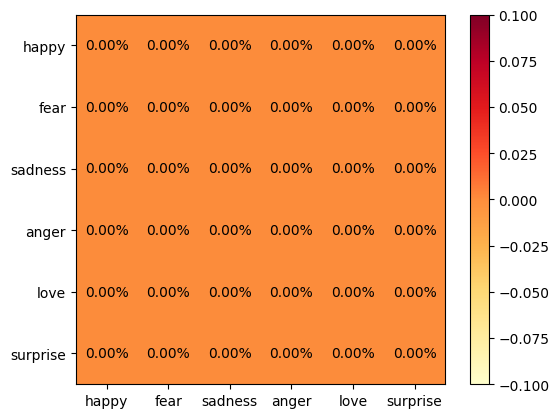

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Liste des sentiments
sentiments = ['happy', 'fear', 'sadness', 'anger', 'love', 'surprise']

# Matrice de contradiction
contradiction_matrix = np.zeros((len(sentiments), len(sentiments)))

# Boucle pour chaque sentiment
for i in range(len(sentiments)):
    for j in range(len(sentiments)):
        # Compter le nombre de documents avec le sentiment i et le mot j
        count = compter_doc_sentiment_et_mot(es, sentiments[i], sentiments[j])
        
        # Calculer le pourcentage
        total_count = compter_doc_sentiment(es, sentiments[i])
        percentage = (count / total_count) * 100
        
        # Stocker le pourcentage dans la matrice de contradiction
        contradiction_matrix[i][j] = percentage

# Création de la HeatMap
fig, ax = plt.subplots()
heatmap = ax.imshow(contradiction_matrix, cmap='YlOrRd')

ax.set_xticks(np.arange(len(sentiments)))
ax.set_yticks(np.arange(len(sentiments)))
ax.set_xticklabels(sentiments)
ax.set_yticklabels(sentiments)

# Ajouter les valeurs sur la HeatMap
for i in range(len(sentiments)):
    for j in range(len(sentiments)):
        text = ax.text(j, i, "{:.2f}%".format(contradiction_matrix[i, j]), ha="center", va="center", color="black")

plt.colorbar(heatmap)
plt.show()